# Logistic Regression with a Neural Network mindset

Welcome to a new project!

In this project, we are going to build a logistic regression classifier, with a Neural Network mindser, to correctly classify pictures as cat or non-cat.


## Table of Contents
- [1 - Import Packages](#1)
- [2 - Load the dataset](#2)
- [3 - Preprocess the dataset](#3)
    - [Reshape the training and test data sets](#pre-1)
    - [Normalize the training and test data sets](#pre-2)
- [4 - Build the model](#4)
    - [4.1 - Define the model architecture](#4-1)
    - [4.2 - Initializing parameters](#4-2)
    - [4.3 - Evaluate the Forward and Backward propagation](#4-3)
    - [4.4 - Perform the optimization](#4-4)
    - [4.5 - Perform the prediction](#4-5)
    - [4.6 - Merge all functions into a mode](#4-6)
- [5 - Further analysis](#5)
- [6 - Test with your own image](#6)

<a name='1'></a>
## 1 - Import Packages ##

- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test our model with our own picture at the end.

In [2]:
# Move to the working directory on Google Drive as using Google Colab
import os

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/Logistic-Regression-with-a-Neural-Network-Mindset-Recognizing-Cats"
  os.chdir(PROJECT_ROOT)
  !pwd
else:
  PROJECT_ROOT ="."

Running on CoLab
/content/drive/MyDrive/GitHub/Logistic-Regression-with-a-Neural-Network-Mindset-Recognizing-Cats


In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Load the dataset ##

The given dataset ("data.h5") containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB)


In [4]:
# Load the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# Figure out the dimensions and shapes of the problem
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Let's visualize first 3 images in the training set 

index =  0
y = [0], it's a 'non-cat' picture.


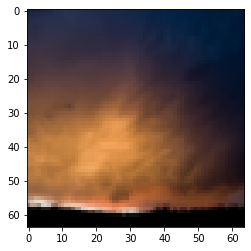

index =  1
y = [0], it's a 'non-cat' picture.


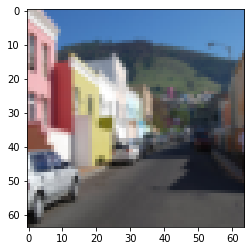

index =  2
y = [1], it's a 'cat' picture.


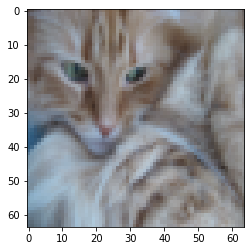

In [5]:
for index in range(3):
  print('==================')
  print("index = ",index)
  plt.imshow(train_set_x_orig[index])
  print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
  plt.show()

<a name='3'></a>
## 3 - Preprocess the dataset ##

<a name='pre-1'></a>
### Reshape the training and test data sets
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image.

In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


<a name='pre-2'></a>
### Normalize the training and test data sets
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to standardize or normalize the dataset so that each feature to have a similar range. But for picture datasets, it is simpler and more convenient and works almost as well to just normalize them by dividing every row of the dataset by 255 (the maximum value of a pixel channel).

In [7]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<a name='4'></a>
## 4 - Build the model ## 

The main steps for building a Neural Network are:
1. Define the model structure/architecture
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (optimization: gradient descent)


<a name='4-1'></a>
### 4.1 - Define the model architecture
The following figure explains why **Logistic Regression is actually a very simple Neural Network**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

<div>
<img src=https://drive.google.com/uc?export=view&id=1LEHbFAzxEqtTz5Dp6CKVVpidXuh-zvjy width="500"/>
</div>


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
- Linear combination: $z^{(i)} = w^T x^{(i)} + b \tag{1}$
- Activation function: $\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)}) = \frac{1}{1 + e^{-z}}\tag{2}$ 
- Loss function: $\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$
- Cost function:$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$


<a name='4-2'></a>
### 4.2 - Initialize parameters

We're initializing w as a vector of zeros and b as zero.

In [8]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    w = np.zeros((dim,1))
    b = 0.0

    return w, b

<a name='4-3'></a>
### 4.3 - Evaluate the Forward and Backward propagation

Now that our parameters are initialized, we can do the "forward" and "backward" propagation steps to compute the cost function and its gradient for learning the parameters.

**Forward Propagation**:
- Activation function: $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

**Backward Propagation**:
- Gradient of the Cost function:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [9]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1.0/(1.0 + np.exp(-z))
    
    return s

In [10]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -np.sum(Y*np.log(A) +(1.0-Y)*np.log(1.0-A))/m
    cost = np.squeeze(np.array(cost))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X,(A-Y).T) / m
    db = np.sum(A-Y) / m
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

<a name='4-4'></a>
### 4.4 - Perform the optimization
- The goal is to learn $w$ and $b$ by minimizing the cost function $J$ using gradient descent. 
- For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [11]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []
    
    for i in range(num_iterations):
        # Calculate the cost and gradient
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update the parameters
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

<a name='4-5'></a>
### 4.5 - Perform the prediction
 There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [14]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):     
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    
    return Y_prediction

<a name='4-6'></a>
### 4.6 - Merge all functions into a model

The overall model will be structured by putting together all the functions implemented in the previous parts together,.


In [15]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros 
    w,b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent 
    params, grads, costs = optimize(w, b, X_train, Y_train, 
                                    num_iterations=num_iterations, 
                                    learning_rate=learning_rate, 
                                    print_cost=print_cost)
    
    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Building the model with model().

In [16]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Let's also plot the cost function and the gradients.

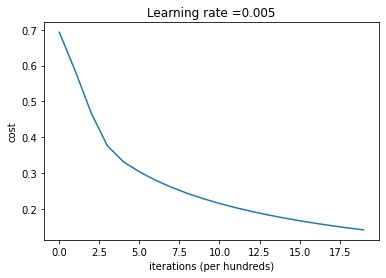

In [17]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(logistic_regression_model["learning_rate"]))
plt.show()

**Interpretation**: 
- We can see the cost decreasing. It shows that the parameters are being learned. 
- Training accuracy is 99%. This is a good sanity check: the model is working and has high enough capacity to fit the training data.
- Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. 
- The model could be trained even more on the training set by increasing the number of iterations. And we might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. To reduce overfitting, several regularization techniques should be applied further. 

y = 0, the model predicted that it is a "cat" picture.


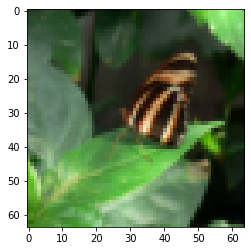

y = 1, the model predicted that it is a "non-cat" picture.


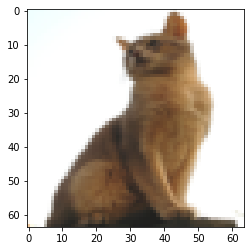

y = 1, the model predicted that it is a "cat" picture.


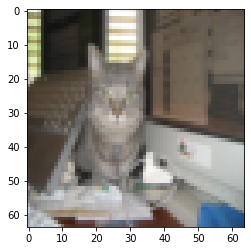

y = 1, the model predicted that it is a "cat" picture.


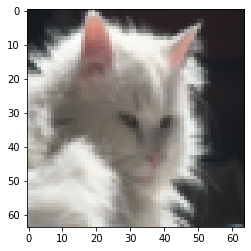

In [41]:
# Example of some pictures that were correctly/wrongly classified.
for index in range(5,9):
  print('==========================')
  print ("y = " + str(test_set_y[0,index]) + ", the model predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")
  plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
  plt.show()
  

<a name='5'></a>
## 5 - Further analysis  ##


#### Choice of learning rate ####

**Reminder**:
- In order for Gradient Descent to work, you must choose the learning rate wisely. 
- The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



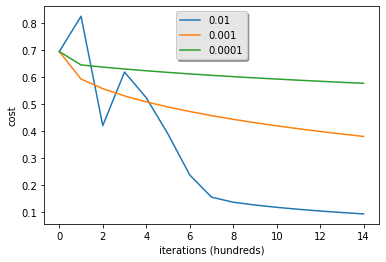

In [22]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we should: 
    - Choose the learning rate that better minimizes the cost function.
    - If the model overfits, use other techniques to reduce overfitting. 


<a name='6'></a>
## 6 - Test with your own image ##
You can use your own image and see the output of the model. To do that:
  1. Add your image to this Jupyter Notebook's directory, in the "images" folder
  2. Change your image's name in the following code
  3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [39]:
 def predict_new_image(new_image): 
  fname = PROJECT_ROOT + "/images/" + new_image
  image = np.array(Image.open(fname).resize((num_px, num_px)))
  plt.imshow(image)

  # preprocess the image to fit your algorithm.
  image = image.reshape((1, num_px * num_px * 3)).T
  image = image / 255.

  # make the prediction
  my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
  predicted_label = int(np.squeeze(my_predicted_image))
  print("predicted_y = " + str(predicted_label) + " ==> a \"" + classes[predicted_label,].decode("utf-8") +  "\" picture.")
  return

predicted_y = 0 ==> a "non-cat" picture.


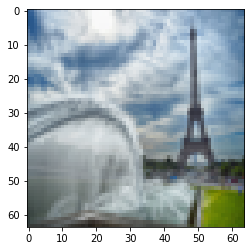

In [40]:
# change this to the name of your image file
my_image = "my_image.jpg" 
predict_new_image(my_image)

<font color='yellow'>
    
**What to remember from this project:**
1. Preprocessing the dataset is important.
2. We implemented each function separately: initialize(), propagate(), optimize(). Then we built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm.

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c